In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from shapely.geometry import Polygon, Point

In [ ]:
#install geopandas as needed
!pip install geopandas

import geopandas as gpd

     |████████████████████████████████| 1.0 MB 4.4 MB/s 
     |████████████████████████████████| 15.4 MB 125 kB/s 
     |████████████████████████████████| 6.3 MB 37.3 MB/s 


In [ ]:
# HELPER FUNCTIONS #


def boundsBuffer(x, buffer=0.15):
    """
    Returns a Polygon geometry that represents a bounding box with a default 15% buffer
    """
    minx, miny, maxx, maxy = x
    buffer_x, buffer_y = np.abs(buffer*(maxx-minx)), np.abs(buffer*(maxy-miny))
    minx -= buffer_x
    maxx += buffer_x
    miny -= buffer_y
    maxy += buffer_y
    
    coords = ((minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny))
    return Polygon(coords)


In [ ]:
### UPLOAD ALL FILES FROM DATA FOLDER ###
### IT MAY TAKE A WHILE (~5 mins) ###


#wildfire boundaries
fires = gpd.read_file('/content/CA_Fire_Polys.geojson')

fires.crs #EPSG:4326

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
#california counties (used to differentiate northern california)
counties = gpd.read_file('/content/CA_Counties_TIGER2016.shp')

counties.crs #EPSG:3857

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
#state of california boundary
state = gpd.read_file('/content/CA_State_TIGER2016.shp')

state.crs #EPSG:3857

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
#consolidate all crs to EPSG:3310, this gives us 1m area accuracy in CA
#values are in meters
ca_crs = 'EPSG:3310'

fires.to_crs(ca_crs, inplace=True)
counties.to_crs(ca_crs, inplace=True)
state.to_crs(ca_crs, inplace=True)

fires.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
#Consider NorCal as anything north of the most southern point in Merced county
merced = counties[counties.NAME == 'San Francisco']

lower_bound = merced.bounds.maxy.values[0]

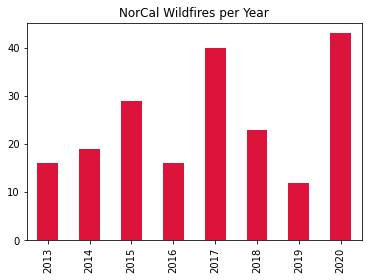

In [ ]:
ACRES_TO_METERS = 4046.86

#get 2015 fires and later
fires_df = fires[fires['YEAR_'].astype(int) >= 2013]

#get fires that are greather than or equal to 5000 acres
fires_df = fires_df.loc[fires_df.GIS_ACRES >= 4500,:].reset_index(drop=True)
fires_df.geometry = fires_df.buffer(10)

#calc fire bounds (keep this for bounding box)
fire_bounds_all = fires_df.bounds
#check if northernmost point of fire point(maxy) is north of lower bound
#is_north_ca_fire = fire_bounds_all.maxy > lower_bound #True if norcal,else False

#spatially filtered fires and bounds
#fires_df = fires_df.loc[is_north_ca_fire,:].reset_index(drop=True)
#fire_bounds = fire_bounds_all.loc[is_north_ca_fire,:].reset_index(drop=True)

#create bounding box polygons
fire_rects = gpd.GeoSeries(fire_bounds_all.apply(boundsBuffer, axis=1), crs=ca_crs)

#subtract wildifre polys from bounding boxes to get unburned area
unburned_polys = fire_rects.difference(fires_df)

#Big spikes in fire occurrences
fires_df.YEAR_.value_counts().sort_index().plot(kind='bar', title='NorCal Wildfires per Year', color='crimson')

In [ ]:
fires_df.area.describe()['mean'] / ACRES_TO_METERS

47163.10184179973

In [ ]:
#avg_fire size: 57120 acres
#median_fire size: 19538 acres
fires_df.GIS_ACRES.describe()

count    1.980000e+02
mean     4.686155e+04
std      9.774397e+04
min      4.533284e+03
25%      8.055944e+03
50%      1.598701e+04
75%      4.118925e+04
max      1.032699e+06
Name: GIS_ACRES, dtype: float64

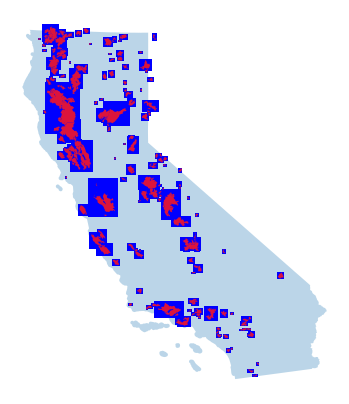

In [ ]:
#NOTE: some fires lay slightly outside of CA
all_state_plot = state.plot(alpha=0.3, figsize=(6,10), aspect=1) #graph fails without aspect=1
all_state_plot.axis('off')

fire_rects.plot(color='blue', ax=all_state_plot,aspect=1)
fires_df.plot(ax=all_state_plot, aspect=1, color='crimson')

In [ ]:
TARGET_FIRES = ['BUTTE', 'CAMP', 'WALKER', 'KINCADE', 'CARR', 'OAK', 
                'REDWOOD VALLEY', 'COVE', 'BUCK', 'CASCADE', 'KING', 
                'CALDWELL', 'FRYING PAN', 'HAPPY', 'ROCKY', 'ATLAS', 'BALD']

is_target = pd.Series([f_name.strip() in TARGET_FIRES for f_name in fires_df.FIRE_NAME])

target_fires = fires_df.loc[is_target,:].sort_values('FIRE_NAME').reset_index(drop=True)

target_unburned = unburned_polys.loc[is_target].reset_index(drop=True)

target_bounds = fire_rects.loc[is_target].reset_index(drop=True)

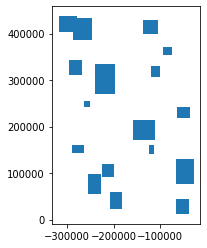

In [ ]:


target_bounds.plot()

In [ ]:
graph_buffer = 30000

graph_min_x, graph_min_y = fire_bounds_all.loc[is_target, ['minx', 'miny']].min().values - graph_buffer
graph_max_x, graph_max_y = fire_bounds_all.loc[is_target, ['maxx', 'maxy']].max().values + graph_buffer

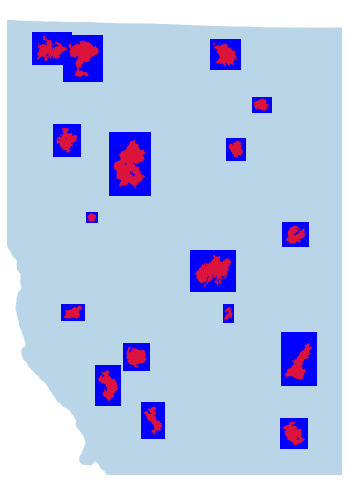

In [ ]:
#bounding boxes in blue, fire polygons in red
state_plot = state.plot(alpha=0.3, figsize=(6,10), aspect=1) #graph fails without aspect=1
state_plot.axis('off')
state_plot.set_ylim(bottom=graph_min_y	, top=graph_max_y)
state_plot.set_xlim(right=graph_max_x	,left=graph_min_x)


fire_rects[is_target].plot(color='blue', ax=state_plot,aspect=1)
fires_df.loc[is_target,:].plot(ax=state_plot, aspect=1, color='crimson')

#TODO: add buffer distance to bounding box?

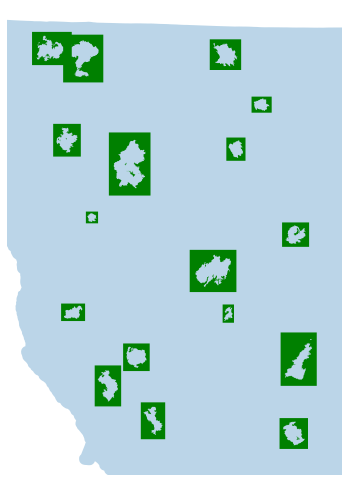

In [ ]:
unburned_plot = state.plot(alpha=0.3, figsize=(6,10), aspect=1) #graph fails without aspect=1
unburned_plot.axis('off')
unburned_plot.set_ylim(bottom=graph_min_y	, top=graph_max_y)
unburned_plot.set_xlim(right=graph_max_x	,left=graph_min_x)

unburned_polys[is_target].plot(color='green', ax=unburned_plot)

In [ ]:
#downloads polygon data for fires burned area

target_fires.to_file('target_fires.shp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


In [ ]:
#downloads polygon data for fires unburned area

target_fires.geometry = target_unburned

target_fires.to_file('target_fires_outlines.shp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


In [ ]:
target_fires.geometry = target_bounds

target_fires.to_file('target_fires_bounds.shp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
target_fires.to_file?